In [36]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.impute import KNNImputer

import phik

import os
import datetime
from datetime import datetime, date, timedelta, time
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.float_format = '{: .3f}'.format

# Описание задачи
Вы сотрудник Отдела Data Science популярного музыкального стримингового сервиса "МиФаСоль". Сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача -- правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Ваши коллеги из отдела работы со звуком подготовили датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. Ваша задача -- разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

**Данные**
- train.csv - информация (~20000) музыкальных треках, которые будут использоваться в качестве обучающих данных.
- test.csv - информация (~5000) музыкальных треках, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение 'music_genre' для каждого трека из этого датасета.
- sample_submit.csv - файл предсказаний в правильном формате.

**Описание столбцов**
- instance_id - идентификатор трека в тестовом наборе.
- music_genre - Целевой признак. Для каждого трека предскажите категориальное значение соответствующее музыкальному жанру трека.
- Описание полей данных
- instance_id - уникальный идентификатор трека
- track_name - название трека
- acousticness - акустичность
- danceability - танцевальность
- duration_ms -продолжительность в милисекундах
- energy - энергичность
- instrumentalness - инструментальность
- key - базовый ключ (нота) произведения
- liveness - привлекательность
- loudness - громкость
- mode - указывает на модальность (мажорную или минорную) трека
- speechiness - выразительность
- tempo - темп
- obtained_date - дата загрузки в сервис
- valence - привлекательность произведения для пользователей сервиса
- music_genre - музыкальный жанр

# Открытие и предобработка данных

In [63]:
df = pd.read_csv('kaggle_music_genre_train.csv')

In [64]:
df.head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.000,Highwayman,0.480,0.670,182653.000,0.351,0.018,D,0.115,-16.842,Major,0.046,101.384,4-Apr,0.450,Country
1,26091.000,Toes Across The Floor,0.243,0.452,187133.000,0.670,0.000,A,0.108,-8.392,Minor,0.035,113.071,4-Apr,0.539,Rock
2,87888.000,First Person on Earth,0.228,0.454,173448.000,0.804,0.000,E,0.181,-5.225,Minor,0.371,80.980,4-Apr,0.344,Alternative
3,77021.000,No Te Veo - Digital Single,0.056,0.847,255987.000,0.873,0.000,G#,0.325,-4.805,Minor,0.080,116.007,4-Apr,0.966,Hip-Hop
4,20852.000,Chasing Shadows,0.227,0.742,195333.000,0.575,0.000,C,0.176,-5.550,Major,0.049,76.494,4-Apr,0.583,Alternative


In [65]:
# приводим id в числовой тип
df.instance_id = df.instance_id.astype('int')
# устанавливаем колонку с id трека как индекс. так будет удобнее в дальнейшем
df = df.set_index(df.instance_id).drop(columns='instance_id')
# оптимизируем float колонки, чтобы они быстрее обрабатывались и занимали меньше места
fcols = df.select_dtypes('float').columns
df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20394 entries, 25143 to 86375
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        20394 non-null  object 
 1   acousticness      20394 non-null  float32
 2   danceability      20394 non-null  float32
 3   duration_ms       20394 non-null  float32
 4   energy            20394 non-null  float32
 5   instrumentalness  20394 non-null  float32
 6   key               19659 non-null  object 
 7   liveness          20394 non-null  float32
 8   loudness          20394 non-null  float32
 9   mode              19888 non-null  object 
 10  speechiness       20394 non-null  float32
 11  tempo             19952 non-null  float32
 12  obtained_date     20394 non-null  object 
 13  valence           20394 non-null  float32
 14  music_genre       20394 non-null  object 
dtypes: float32(10), object(5)
memory usage: 1.7+ MB


Проверяем на отсутствующие значения.

In [67]:
df.isna().sum()

track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 735
liveness              0
loudness              0
mode                506
speechiness           0
tempo               442
obtained_date         0
valence               0
music_genre           0
dtype: int64

Забегая вперед, я знаю, что в тестовом датасете также будут встречаться отсутствующие значения, поэтому нужно научить модель с ними справляться. Делать я это буду с помощью `KNN imputer` из sklearn

track_name
Values (first 5 unique): ['"99"', '"Christen, ätzet diesen Tag", BWV 63: I. Choral "Christen, ätzet diesen Tag"', '"Concerto Funebre" con hautbois sordini e salmoè, violino principale e viole da gamba (Si Bem. Maggiore, RV 579): II. Allegro poco poco', '"DEVILS NEVER CRY"(スタッフロール)', '"F"']
----------
acousticness
Values (first 5 unique): [0.0, 1.02e-06, 1.27e-06, 1.37e-06, 1.38e-06]
max: 0.996 min: 0.0
median: 0.12099999934434891


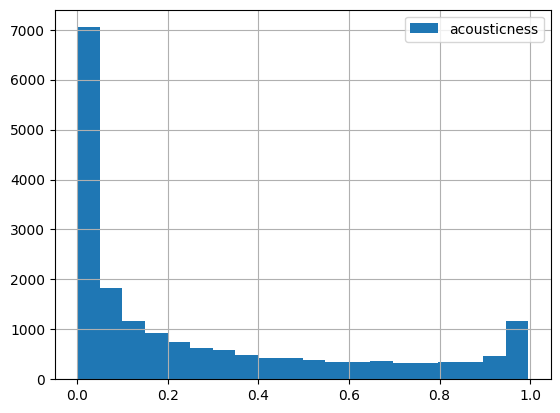

----------
danceability
Values (first 5 unique): [0.06, 0.0602, 0.0606, 0.061, 0.0614]
max: 0.978 min: 0.06
median: 0.5699999928474426


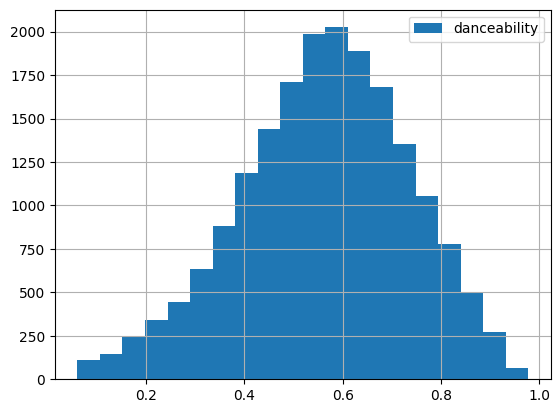

----------
duration_ms
Values (first 5 unique): [-1.0, 15509.0, 16316.0, 27179.0, 29040.0]
max: 4497994.0 min: -1.0
median: 219709.5


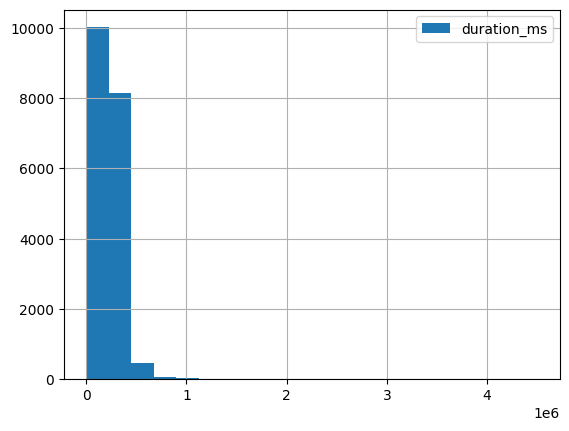

----------
energy
Values (first 5 unique): [0.00101, 0.00104, 0.0011, 0.00135, 0.00158]
max: 0.999 min: 0.00101
median: 0.6660000085830688


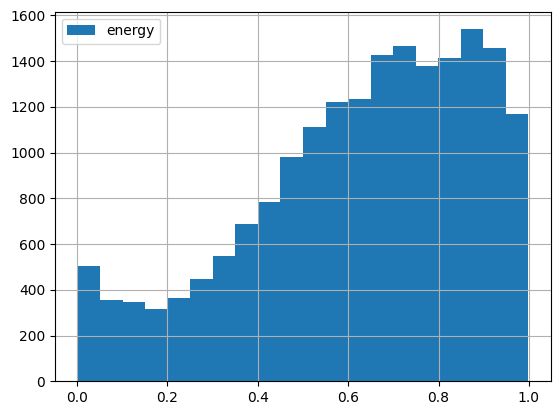

----------
instrumentalness
Values (first 5 unique): [0.0, 1e-06, 1.01e-06, 1.02e-06, 1.03e-06]
max: 0.996 min: 0.0
median: 0.00014600000577047467


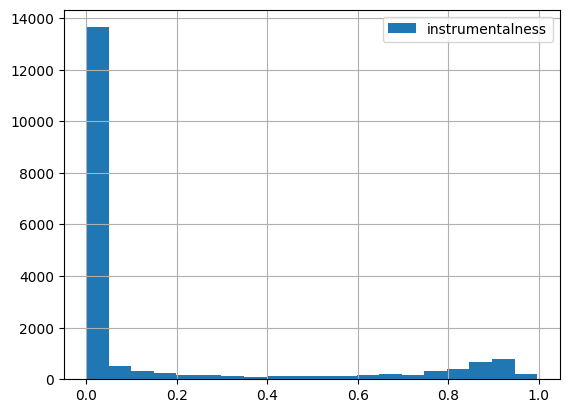

----------
key
Values (first 5 unique): ['A', 'A#', 'B', 'C', 'C#']


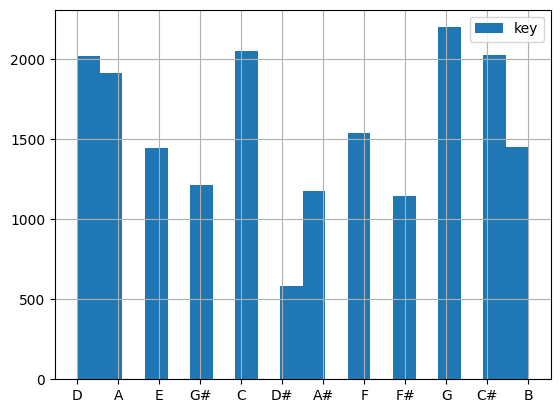

----------
liveness
Values (first 5 unique): [0.0136, 0.0169, 0.0194, 0.0209, 0.0212]
max: 1.0 min: 0.0136
median: 0.12999999523162842


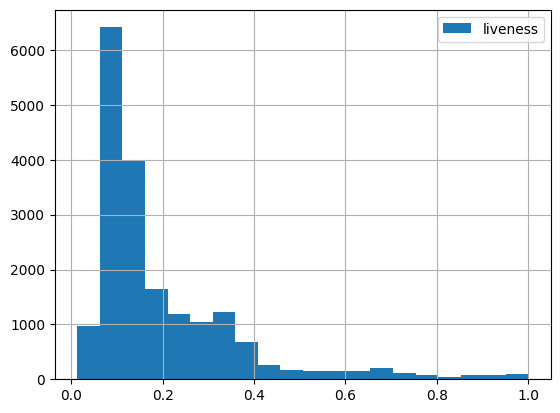

----------
loudness
Values (first 5 unique): [-44.406, -44.108, -43.407, -42.512, -42.175]
max: 3.744 min: -44.406
median: -7.044000148773193


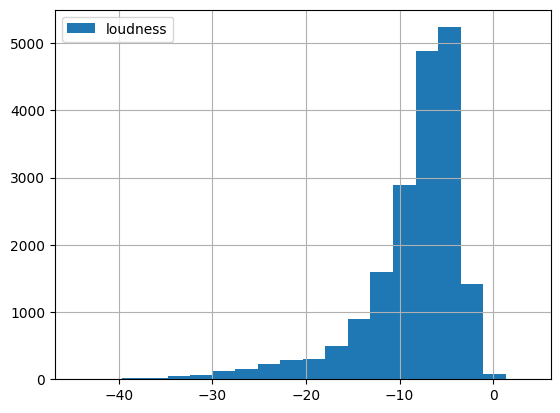

----------
mode
Values (first 5 unique): ['Major', 'Minor']


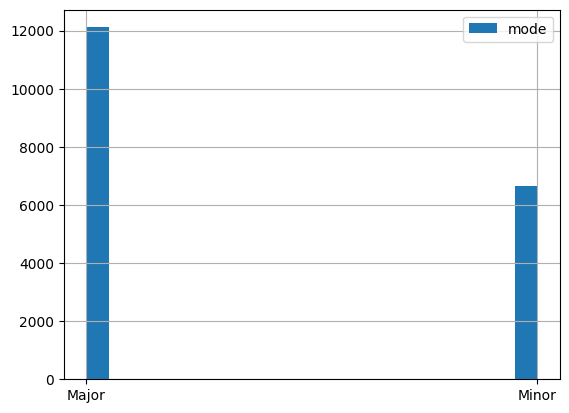

----------
speechiness
Values (first 5 unique): [0.0223, 0.0224, 0.0225, 0.0226, 0.0227]
max: 0.932 min: 0.0223
median: 0.04894999973475933


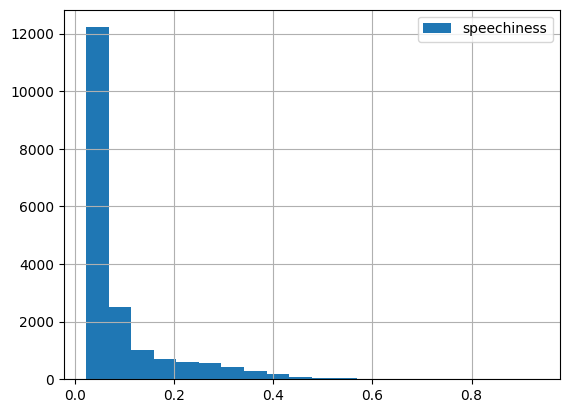

----------
tempo
Values (first 5 unique): [34.765, 34.856, 46.591, 46.718, 47.587]
max: 220.041 min: 34.765
median: 120.01100158691406


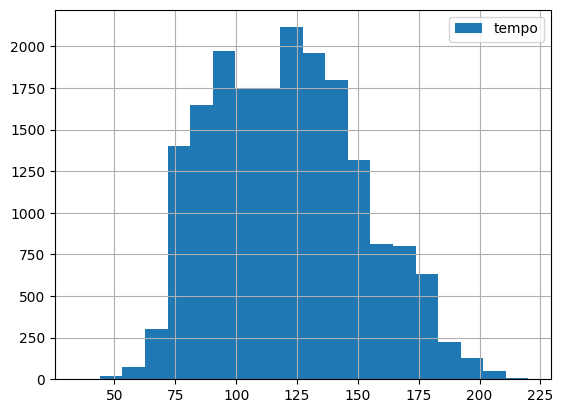

----------
obtained_date
Values (first 5 unique): ['1-Apr', '3-Apr', '4-Apr', '5-Apr']


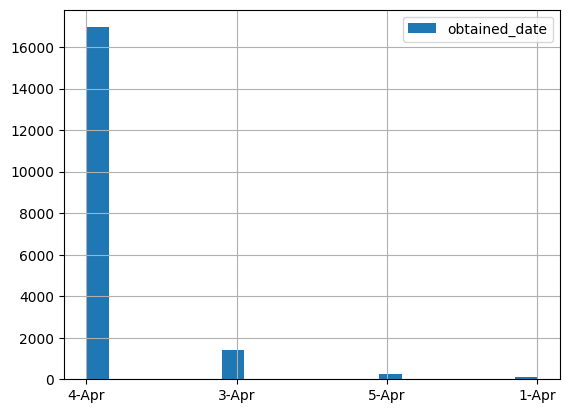

----------
valence
Values (first 5 unique): [0.0, 0.0193, 0.0234, 0.0241, 0.0251]
max: 0.992 min: 0.0
median: 0.4569999873638153


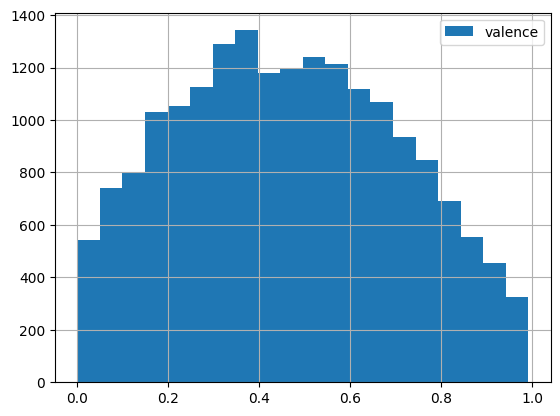

----------
music_genre
Values (first 5 unique): ['Alternative', 'Anime', 'Blues', 'Classical', 'Country']


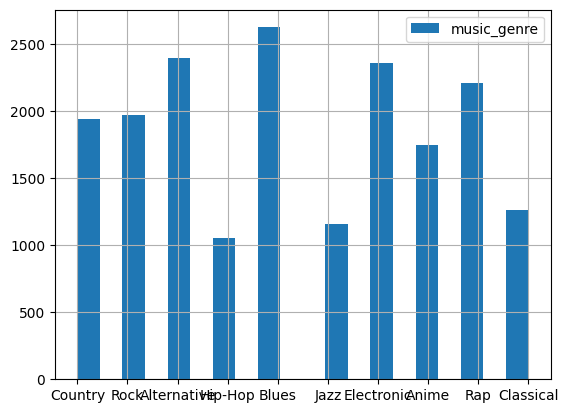

----------


In [17]:
for col in df.columns:
    print(col)
    print('Values (first 5 unique):', sorted(df[col].unique())[:5])
    if df[col].dtype != 'O':
        print('max:', df[col].max(), 'min:', df[col].min())
        print('median:', df[col].quantile(0.5))
    if col != 'track_name':
        df[col].hist(legend=True, bins=20)
        plt.show()
    print('-'*10)

In [68]:
# проверка на дисбаланс классов
df.music_genre.value_counts(normalize=True)

Blues          0.140
Alternative    0.128
Electronic     0.126
Rap            0.119
Rock           0.106
Country        0.104
Anime          0.093
Classical      0.067
Jazz           0.061
Hip-Hop        0.056
Name: music_genre, dtype: float64

## Проверка на дубли

In [186]:
df[df.duplicated(subset=df.columns[:-1])]

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,mode,speechiness,tempo,valence,music_genre
instance_id,,,,,,,,,,,,
23587,0.228,0.454,173448.000,0.804,0.000,E,0.181,Minor,0.371,80.980,0.344,Rock
84391,0.038,0.512,94547.000,0.576,0.036,G#,0.198,Minor,0.283,75.978,0.319,Alternative
79141,0.300,0.617,161827.000,0.686,0.000,D,0.105,Major,0.245,79.252,0.544,Rap
49551,0.000,0.400,209049.000,0.792,0.085,B,0.185,Major,0.037,117.819,0.338,Blues
36964,0.070,0.733,226581.000,0.676,0.000,A#,0.208,Minor,0.043,97.448,0.701,Rap
...,...,...,...,...,...,...,...,...,...,...,...,...
72215,0.000,0.406,222049.000,0.952,0.025,G#,0.198,Major,0.042,88.563,0.534,Rap
42562,0.006,0.554,240453.000,0.864,0.000,A,0.132,Major,0.039,112.523,0.299,Alternative
66420,0.024,0.746,222093.000,0.873,0.000,G,0.354,Major,0.128,148.075,0.817,Rap


In [188]:
# удаляем дубли
df = df.drop_duplicates(subset=df.columns[:-1])

In [69]:
# столбец с названием трека не несет ценности при обучении модели
df.drop(columns='track_name', inplace=True)

## Проверка столбца duration_ms на выбросы

Построим boxplot

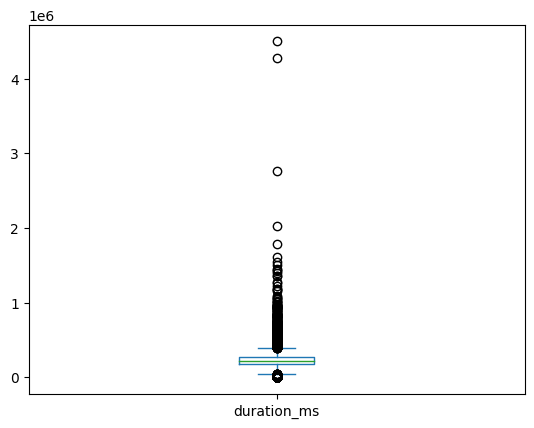

In [70]:
df.duration_ms.plot(kind='box');

Видим большое кол-во выбивающихся точек. Просмотрим их более детально

In [71]:
df.duration_ms.sort_values(ascending=False).head(10) / (1000*60)

instance_id
31587    74.967
33452    71.267
68269    46.082
44557    33.655
33672    29.641
46356    26.956
30590    25.702
21079    25.160
68767    24.092
68942    23.859
Name: duration_ms, dtype: float32

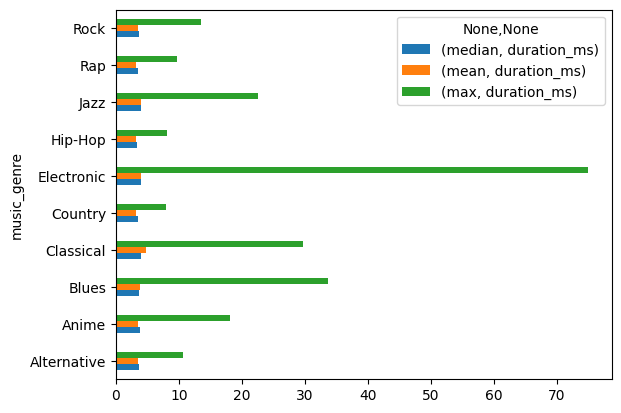

In [72]:
duration = df.pivot_table(index='music_genre', values='duration_ms', aggfunc=['median', 'mean', 'max'])
duration = duration / 1000 / 60 # переводим в минуты
duration.plot(kind='barh');

Видим, что у треков каждого жанра есть аномально длинные композиции.  
Путем точеченой ручной проверки я выяснил, что это ошибочно: в действительности длина трека не такая.  
Очистим наиболее длинные треки в каждом жанре.  

In [73]:
rows = df.shape[0]

In [74]:
for j in df.music_genre.unique():
    qs = df[df.music_genre == j].duration_ms.quantile([0.25, 0.75])
    Q1, Q3 = qs[0.25], qs[0.75]
    IQR = Q3 - Q1
    ind = df[(df.music_genre == j) & (df.duration_ms > (Q3 + IQR * 1.5))].index
    # оставляем только строки без выбросов
    df = df[~df.index.isin(ind)]

In [75]:
df.shape

(19762, 14)

Узнаем, многим ли мы пожертвовали при очистке.

In [76]:
print('Очищено', round((rows - df.shape[0]) / rows, 4) * 100, '% строк')

Очищено 3.1 % строк


Значение выглядит приемлемым.

Посмотрим, может ли повлиять obtained_date - дата загрузки в сервис - на жанр трека.

In [77]:
df.pivot_table(columns=['obtained_date'], index='music_genre', values='key', aggfunc='count')

obtained_date,1-Apr,3-Apr,4-Apr,5-Apr
music_genre,,,,
Alternative,9,151,2261,18
Anime,17,166,1617,30
Blues,23,303,2278,17
Classical,38,315,844,69
Country,1,114,1867,9
Electronic,8,71,2273,21
Hip-Hop,3,17,1038,29
Jazz,14,131,979,24
Rap,10,56,2173,51


Визуальный анализ показал, что связи между загрузкой в сервис и жанром трека нет связи. Колонку можно удалить.

In [78]:
df = df.drop(columns='obtained_date')

**Выводы:**
- Название трека удаляем, т.к. для обучения моделей он ничего не даст
- Очищены выбросы в столбце `duration_ms`
- Остальные столбцы выглядят адекватно
- Удалены дубли
- Таргет - music_genre - содержит дисбаланс классов, т.к., например, hip-hop (~1000) в 2,5 раза реже встречается, чем Blues - ~2500
- Отсутствующие значения есть, впоследствии они будут обработаны KNN imputer
- Столбец `obtained_date` удален, т.к. не будет иметь ценности для модели

# Подготовка к обучению модели

Проверим признаки на мультиколлинеарность с помощью библиотеки `phik`.  

Суть метода базируется на подсчете **хи-квадрат статистики**, затем ее трансформации в нечто подобное коэффициенту корреляции только на отрезке от 0 (нулевая взаимосвязь) до 1 (максимальная взаимосвязь). С этой целью разработчики считают аналогичную хи-квадрат статистику для различных значений корреляции p случайных величин из двумерного нормального распределения. Опуская нюансы, возвращается p двумерного распределения, соответствующее найденной хи-квадрат статистике между заданными признаками.

In [25]:
phik_matr = df_cleared.drop(columns='music_genre').phik_matrix()

AttributeError: 'DataFrame' object has no attribute 'phik_matrix'

Визуализируем с помощью seaborn

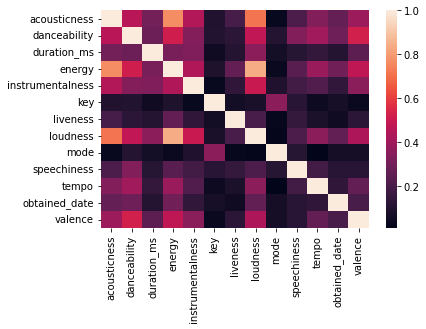

In [73]:
sns.heatmap(phik_matr);

In [68]:
phik_matr[phik_matr > 0.7].fillna('')

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
acousticness,1.000,,,0.767,,,,0.711,,,,,
danceability,,1.000,,,,,,,,,,,
duration_ms,,,1.000,,,,,,,,,,
energy,0.767,,,1.000,,,,0.839,,,,,
instrumentalness,,,,,1.000,,,,,,,,
key,,,,,,1.000,,,,,,,
liveness,,,,,,,1.000,,,,,,
loudness,0.711,,,0.839,,,,1.000,,,,,
mode,,,,,,,,,1.000,,,,
speechiness,,,,,,,,,,1.000,,,


Видим высокую (более 70%) корреляцию между признаками:
- acousticness и loudness
- energy и loudness  

Таким образом, loudness можно удалить (т.к. именно этот столбец сильно коррелирует с двумя другими), чтобы избежать переобучения модели.

In [79]:
df.drop(columns='loudness', inplace=True)

Создадим функцию, которая объединит все этапы очистки данных в целях обработки тестовых данных.

In [80]:
def prepare_raw(raw):
    # приводим id в числовой тип
    raw.instance_id = raw.instance_id.astype('int')
    # устанавливаем колонку с id трека как индекс. так будет удобнее в дальнейшем
    raw = raw.set_index(raw.instance_id).drop(columns='instance_id')
    # оптимизируем float колонки, чтобы они быстрее обрабатывались и занимали меньше места
    fcols = raw.select_dtypes('float').columns
    raw[fcols] = raw[fcols].apply(pd.to_numeric, downcast='float')

    # очистка ненужных колонок
    raw.drop(columns=['track_name', 'loudness', 'obtained_date'], inplace=True)

    return raw

# Разработка модели

Создаем features & target

In [189]:
X = df.drop(columns='music_genre')
Y = df['music_genre']

In [82]:
SEED = 777 # for random_state

## Линейные модели

Будем максимизировать f1-score как наиболее подходящий для задачи классификации.  
Для задач мультиклассовой классификации можно использовать разные виды метрик f-1.  
Мой выбор - **f1_micro**, т. к. она отлично подходит для несбалансированных классов.

In [88]:
def linear_pipeline(model):
    '''
    функция создает обыкновенный pipeline с one-hot encoder и StandartScaler для линейных моделей.
    на выходе возвращает pipeline
    '''
    # Объявляем scaler и OneHotEncoder() для числовых и категориальных переменных соответственно
    scaler = StandardScaler() 
    ohe = OneHotEncoder(handle_unknown='ignore', drop='first')

    # делаем кодировку колонок (ohe), скалирование и обработку пустых значений
    column_transformer = make_column_transformer(
        (scaler, make_column_selector(dtype_include='number')),
        (ohe, make_column_selector(dtype_include='object')),
        remainder='passthrough')

    # итоговый pipeline
    pipeline = Pipeline([("preprocessing", column_transformer),
                         ("imputer", KNNImputer()),
                         ("model", model)])
    return pipeline

### LogisticRegression

In [89]:
pipeline = linear_pipeline(LogisticRegression(random_state=SEED))

Я воспользуюсь RandomizedSearchCV для более быстрой оценки тех или иных гиперпараметров, затем визуализирую результаты работы (score) каждого параметра, чтобы понять, какие из них подходят лучше. Если модель будет покажет хорошие результаты, уточню поиск параметров с помощью GridSearchCV.

In [90]:
%%time

param_grid = {'model__solver': ['newton-cg', 'lbfgs', 'saga', 'sag'],
              'model__max_iter': np.linspace(100, 2000, 20).astype('int'),
              'model__class_weight': ['balanced', None],
              'model__C': [0.1, 1, 10, 100, 1000], #np.logspace(-4, 3, 20),
              'model__penalty': ['none', 'l1', 'l2'],
              'imputer__n_neighbors': [3,5,7,10]
             }

loggs = RandomizedSearchCV(pipeline, 
                  param_distributions=param_grid, 
                  n_iter = 100,
                  cv = 5, 
                  n_jobs=-1, 
                  verbose=1,
                  scoring='f1_micro',
                  random_state=SEED,
#                   error_score='raise'
                  )

loggs.fit(X, Y)
print('Best params:', loggs.best_params_)
print('Best score:', loggs.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
100 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  F

Best params: {'model__solver': 'lbfgs', 'model__penalty': 'l2', 'model__max_iter': 400, 'model__class_weight': None, 'model__C': 0.1, 'imputer__n_neighbors': 5}
Best score: 0.39550675651455214
CPU times: user 16.7 s, sys: 1min 2s, total: 1min 19s
Wall time: 1min 28s


In [91]:
# обрабатываем результаты работы
rs_df = pd.DataFrame(loggs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)

rs_df = rs_df[rs_df.mean_test_score.notna()]

columns_to_show = ['param_' + x for x in param_grid.keys()] + ['mean_test_score', 'rank_test_score']
rs_df = rs_df[columns_to_show]
rs_df = rs_df.fillna('None')

# rs_df['param_model__C'] = rs_df['param_model__C'].astype('float64').round(5)
params_to_show = list(rs_df.columns[:-2])

rs_df.head(10)

,param_model__solver,param_model__max_iter,param_model__class_weight,param_model__C,param_model__penalty,param_imputer__n_neighbors,mean_test_score,rank_test_score
0,lbfgs,400,None,0.100,l2,5,0.396,1
1,saga,800,None,0.100,l2,3,0.396,2
2,newton-cg,1900,None,0.100,l2,3,0.396,2
3,sag,1000,None,0.100,l2,7,0.395,4
4,saga,300,None,1.000,l2,7,0.394,5
5,saga,700,None,1.000,l1,10,0.394,6
6,lbfgs,1100,None,1.000,l2,10,0.394,7
7,lbfgs,800,None,1000.000,l2,3,0.394,8
8,newton-cg,300,None,100.000,none,3,0.394,8
9,newton-cg,200,None,10.000,none,3,0.394,8


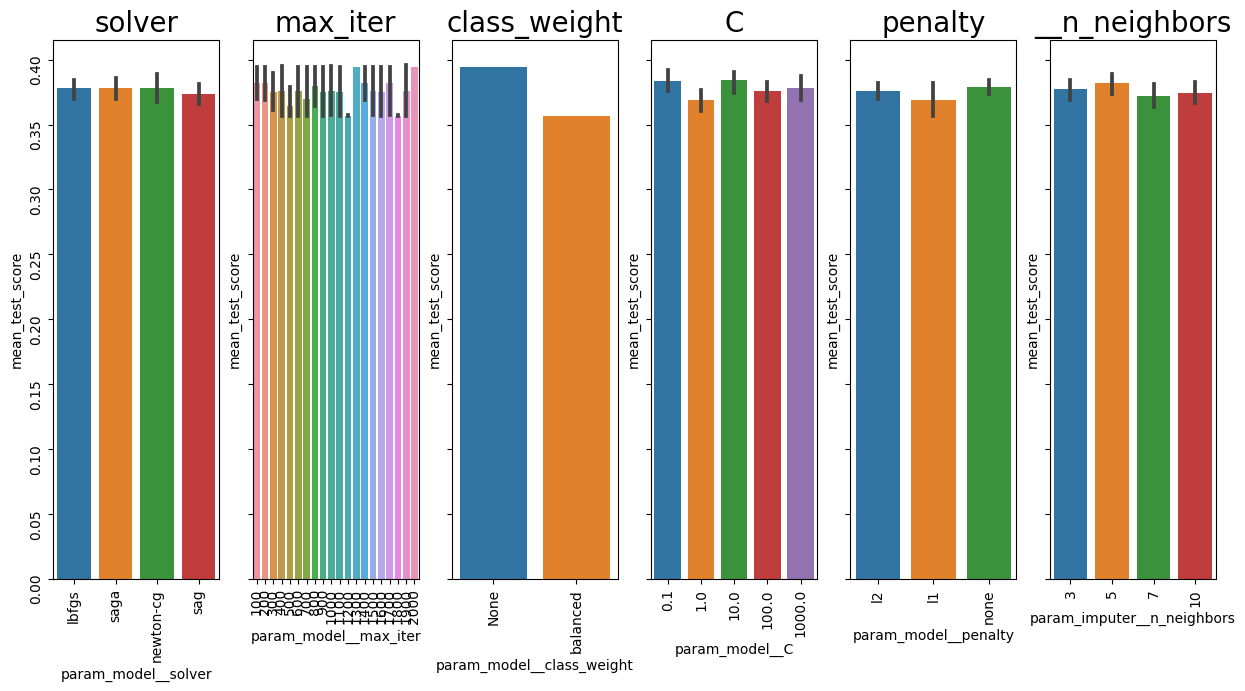

In [92]:
# графики, показывающие средний скор в зависимости от значения параметра
params_to_show = columns_to_show[:-2]
fig, axs = plt.subplots(ncols=len(params_to_show), nrows=1, sharey=True)
fig.set_size_inches(15,7)
for i in range(len(params_to_show)):
    sns.barplot(x=params_to_show[i], y='mean_test_score', data=rs_df, ax=axs[i])
    axs[i].set_title(label = params_to_show[i][13:], size=20)
    axs[i].tick_params(rotation=90)

Логистическая регрессия не показывает впечатляющих результатов. Попробуем другую модель - **SVC** - метод опорных векторов.

### SVM

In [174]:
# создаем пайплайн для svc
svc_pipeline = linear_pipeline(SVC(random_state=SEED))

In [94]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [95]:
%%time

# сетка параметров
param_grid = {'model__kernel': ['linear', 'rbf'],
              'model__max_iter': [-1] + list(np.linspace(3000, 10000, 20).astype('int')),
              'model__class_weight': [None, 'balanced'],
              'model__C': [0.1, 1, 10, 100],
              'model__gamma': [1, 0.1, 0.01, 'scale', 'auto'],
              'preprocessing__standardscaler': [MinMaxScaler(), StandardScaler()],
              'imputer__n_neighbors': [3,5,7,10]
             }

gs = RandomizedSearchCV(svc_pipeline, 
                  param_distributions=param_grid, 
                  n_iter = 50,
                  cv = 5, 
                  n_jobs=-1, 
                  verbose=1,
                  scoring='f1_micro',
                  random_state=SEED,
#                   error_score='raise'
                  )

gs.fit(X, Y)
print('Best params:', gs.best_params_)
print('Best score:', gs.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best params: {'preprocessing__standardscaler': StandardScaler(), 'model__max_iter': 5947, 'model__kernel': 'rbf', 'model__gamma': 0.1, 'model__class_weight': None, 'model__C': 1, 'imputer__n_neighbors': 3}
Best score: 0.445400536260576
CPU times: user 29.2 s, sys: 6.64 s, total: 35.9 s
Wall time: 8min 26s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Sett

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Sett

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Sett

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Sett

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Sett

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Sett

In [103]:
# обрабатываем результаты работы модели
rs_df = pd.DataFrame(gs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)

rs_df = rs_df[rs_df.mean_test_score.notna()]

columns_to_show = ['param_' + x for x in param_grid.keys()] + ['mean_test_score', 'rank_test_score']
rs_df = rs_df[columns_to_show]
rs_df = rs_df.fillna('None')
rs_df['param_preprocessing__standardscaler'] = rs_df['param_preprocessing__standardscaler'].astype('str')

params_to_show = list(rs_df.columns[:-2])

rs_df.head(10)

,param_model__kernel,param_model__max_iter,param_model__class_weight,param_model__C,param_model__gamma,param_preprocessing__standardscaler,param_imputer__n_neighbors,mean_test_score,rank_test_score
0,rbf,5947,None,1.000,0.100,StandardScaler(),3,0.445,1
1,rbf,7052,None,1.000,0.100,StandardScaler(),7,0.445,2
2,rbf,4842,None,1.000,auto,StandardScaler(),7,0.439,3
3,rbf,8157,None,10.000,scale,StandardScaler(),5,0.427,4
4,rbf,-1,None,100.000,auto,MinMaxScaler(),3,0.422,5
5,rbf,5947,None,10.000,0.100,MinMaxScaler(),10,0.418,6
6,rbf,3736,None,10.000,0.100,MinMaxScaler(),7,0.418,7
7,rbf,7052,balanced,100.000,0.010,StandardScaler(),10,0.410,8
8,rbf,8894,balanced,10.000,scale,StandardScaler(),5,0.407,9
9,rbf,8157,balanced,100.000,0.010,StandardScaler(),5,0.407,10


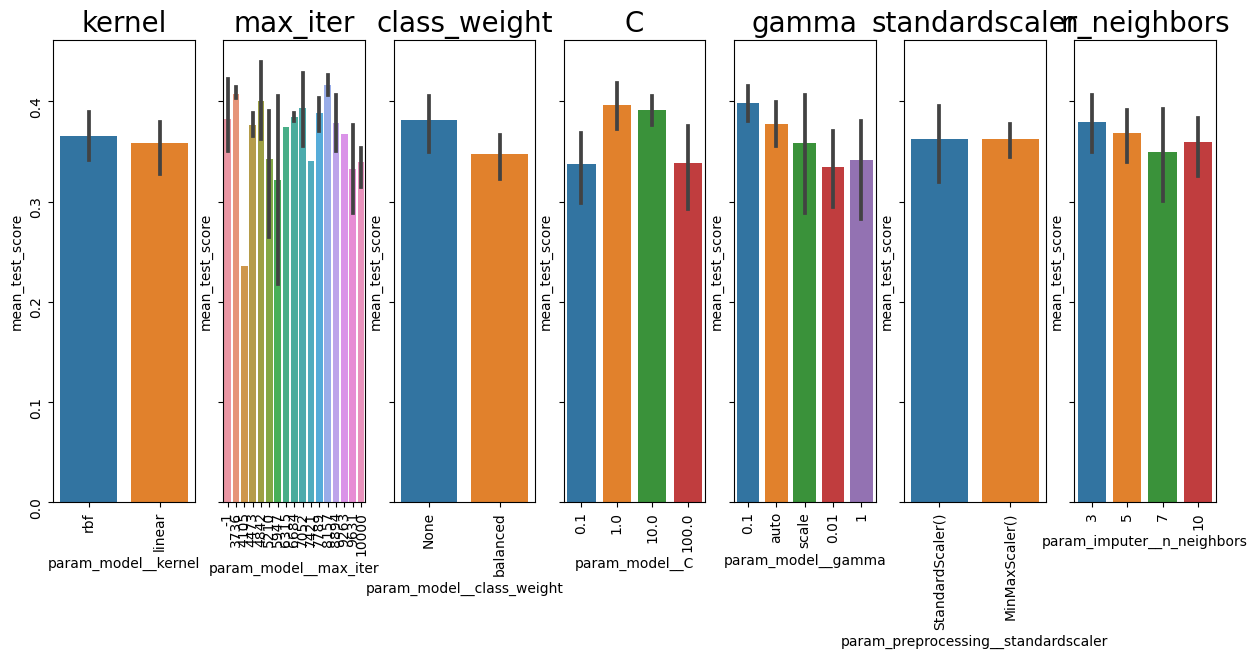

In [106]:
# графики, показывающие средний скор в зависимости от значения параметра
params_to_show = columns_to_show[:-2]
fig, axs = plt.subplots(ncols=len(params_to_show), nrows=1, sharey=True)
fig.set_size_inches(15,6)
for i in range(len(params_to_show)):
    sns.barplot(x=params_to_show[i], y='mean_test_score', data=rs_df, ax=axs[i])
    axs[i].set_title(label = params_to_show[i][params_to_show[i].find('__')+2:], size=20)
    axs[i].tick_params(rotation=90)

Результат хороший (забегая вперед, лучше, чем у деревянных моделей).

Поэтому попробую его максимизировать по найденным пераметрам с помощью уже GridSearch.

In [190]:
%%time

# сетка параметров
param_grid = {'model__kernel': ['rbf'],
              'model__max_iter': [-1, 6000, 7000],
              'model__class_weight': [None],
              'model__C': [1, 10],
              'model__gamma': [0.1, 'auto'],
              'preprocessing__standardscaler': [MinMaxScaler(), StandardScaler()]
             }

fine_gs = GridSearchCV(svc_pipeline, 
                  param_grid=param_grid, 
                  cv = 5, 
                  n_jobs=-1, 
                  verbose=1,
                  scoring='f1_micro'
                  )

fine_gs.fit(X, Y)
print('Best params:', fine_gs.best_params_)
print('Best score:', fine_gs.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params: {'model__C': 1, 'model__class_weight': None, 'model__gamma': 0.1, 'model__kernel': 'rbf', 'model__max_iter': -1, 'preprocessing__standardscaler': StandardScaler()}
Best score: 0.4491701244813278
CPU times: user 26.1 s, sys: 6.5 s, total: 32.6 s
Wall time: 4min 2s


## KNN

In [194]:
pipeline = linear_pipeline(KNeighborsClassifier())

In [195]:
%%time

# сетка параметров
param_grid = {'model__n_neighbors': range(20,40),
              'model__weights': ['uniform', 'distance'],
              'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'model__leaf_size': np.linspace(10, 50, 15).astype('int')
             }

knn_gs = RandomizedSearchCV(pipeline, 
                  param_distributions=param_grid, 
                  n_iter = 50,
                  cv = 5, 
                  n_jobs=-1, 
                  verbose=1,
                  scoring='f1_micro',
                  random_state=SEED,
#                   error_score='raise'
                  )

knn_gs.fit(X, Y)
print('Best params:', knn_gs.best_params_)
print('Best score:', knn_gs.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best params: {'model__weights': 'distance', 'model__n_neighbors': 32, 'model__leaf_size': 47, 'model__algorithm': 'auto'}
Best score: 0.4006742738589212
CPU times: user 3.34 s, sys: 6.29 s, total: 9.63 s
Wall time: 53.8 s


In [196]:
# обрабатываем результаты работы модели
rs_df = pd.DataFrame(knn_gs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)

rs_df = rs_df[rs_df.mean_test_score.notna()]

columns_to_show = ['param_' + x for x in param_grid.keys()] + ['mean_test_score', 'rank_test_score']
rs_df = rs_df[columns_to_show]
rs_df = rs_df.fillna('None')

params_to_show = list(rs_df.columns[:-2])

rs_df.head(10)

,param_model__n_neighbors,param_model__weights,param_model__algorithm,param_model__leaf_size,mean_test_score,rank_test_score
0,32,distance,auto,47,0.401,1
1,32,distance,kd_tree,18,0.401,2
2,32,distance,kd_tree,38,0.401,2
3,29,distance,brute,35,0.401,4
4,29,distance,kd_tree,15,0.401,4
5,33,distance,auto,18,0.400,6
6,35,uniform,ball_tree,32,0.400,7
7,34,distance,auto,35,0.400,8
8,34,distance,brute,32,0.400,8
9,34,distance,kd_tree,24,0.400,8


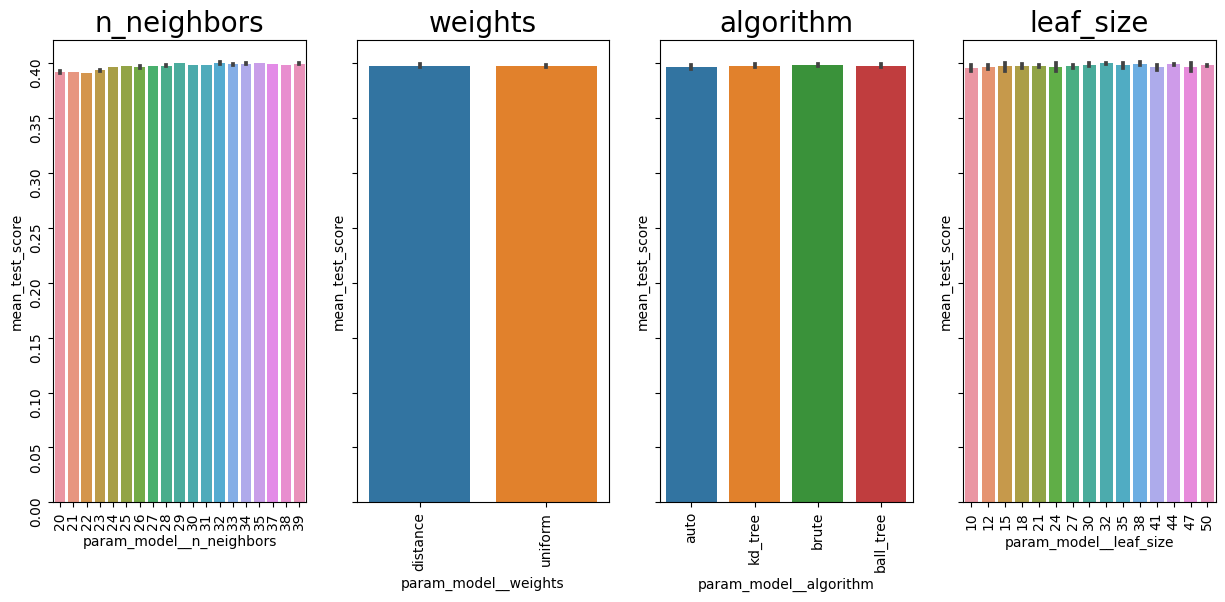

In [197]:
# графики, показывающие средний скор в зависимости от значения параметра
params_to_show = columns_to_show[:-2]
fig, axs = plt.subplots(ncols=len(params_to_show), nrows=1, sharey=True)
fig.set_size_inches(15,6)
for i in range(len(params_to_show)):
    sns.barplot(x=params_to_show[i], y='mean_test_score', data=rs_df, ax=axs[i])
    axs[i].set_title(label = params_to_show[i][params_to_show[i].find('__')+2:], size=20)
    axs[i].tick_params(rotation=90)

Результат у KNN стабильный 0.4 практически независимо от гиперпараметров, вряд ли здесь можно что-то улучшить.

## "Деревянные" модели

In [198]:
def wooden_pipeline(model):
    '''
    создает обыкновенный пайплан с порядковым кодированием текстовых фичей для деревянных моделей
    '''
    # Порядковое кодирование 
    encoder = OrdinalEncoder(handle_unknown = 'error')
    obj_cols = X.select_dtypes('object').columns
    encoder_preprocessor = ColumnTransformer([('ord_encoder', encoder, obj_cols)])
    # финальный пайплайн
    pipeline = Pipeline([("preprocessing", encoder_preprocessor),
                         ("imputer", KNNImputer()),
                         ('model', model)])
    return pipeline

### DecisionTreeClassifier

In [199]:
dt_pipeline = wooden_pipeline(DecisionTreeClassifier(random_state=SEED))

In [200]:
%%time

param_grid = {'model__max_features': ['auto', 'sqrt', 'log2', None],
              'model__max_depth': list(range(5,30)),
              'model__min_samples_leaf': [int(x) for x in np.linspace(start = 2, stop = 100, num = 10)],
              'model__min_samples_split': [int(x) for x in np.linspace(start = 2, stop = 100, num = 10)],
              'model__class_weight': ['balanced', None],
              'model__criterion' : ["gini", "entropy"],
              'model__max_leaf_nodes': [int(x) for x in np.linspace(start = 2, stop = 100, num = 10)],
              'imputer__n_neighbors': [3,5,7,10]
             }

gs = RandomizedSearchCV(dt_pipeline, 
                  param_grid, 
                  n_iter = 500,
                  cv = 5, 
                  n_jobs=-1, 
                  verbose = 1,
                  scoring='f1_micro',
                  random_state=SEED)


gs.fit(X, Y)
print(gs.best_params_)
print(gs.best_score_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
{'model__min_samples_split': 78, 'model__min_samples_leaf': 45, 'model__max_leaf_nodes': 34, 'model__max_features': None, 'model__max_depth': 5, 'model__criterion': 'entropy', 'model__class_weight': None, 'imputer__n_neighbors': 3}
0.175
CPU times: user 19.1 s, sys: 7.83 s, total: 27 s
Wall time: 5min 56s


In [201]:
# обрабатываем результаты работы
rs_df = pd.DataFrame(gs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)

rs_df = rs_df[rs_df.mean_test_score.notna()]

columns_to_show = ['param_' + x for x in param_grid.keys()] + ['mean_test_score', 'rank_test_score']
rs_df = rs_df[columns_to_show]
rs_df = rs_df.fillna('None')

params_to_show = list(rs_df.columns[:-2])

rs_df.head(10)

,param_model__max_features,param_model__max_depth,param_model__min_samples_leaf,param_model__min_samples_split,param_model__class_weight,param_model__criterion,param_model__max_leaf_nodes,param_imputer__n_neighbors,mean_test_score,rank_test_score
0,None,5,45,78,None,entropy,34,3,0.175,1
1,None,28,45,100,None,entropy,23,5,0.175,2
2,auto,7,23,89,None,gini,100,3,0.175,3
3,log2,7,34,12,None,gini,23,3,0.175,4
4,log2,7,56,56,None,gini,100,3,0.175,5
5,sqrt,6,34,89,None,entropy,34,3,0.175,6
6,None,12,23,23,None,gini,78,7,0.174,7
7,auto,6,2,100,None,entropy,23,3,0.174,8
8,auto,24,23,34,None,entropy,34,3,0.174,9
9,log2,11,45,78,None,entropy,34,3,0.174,10


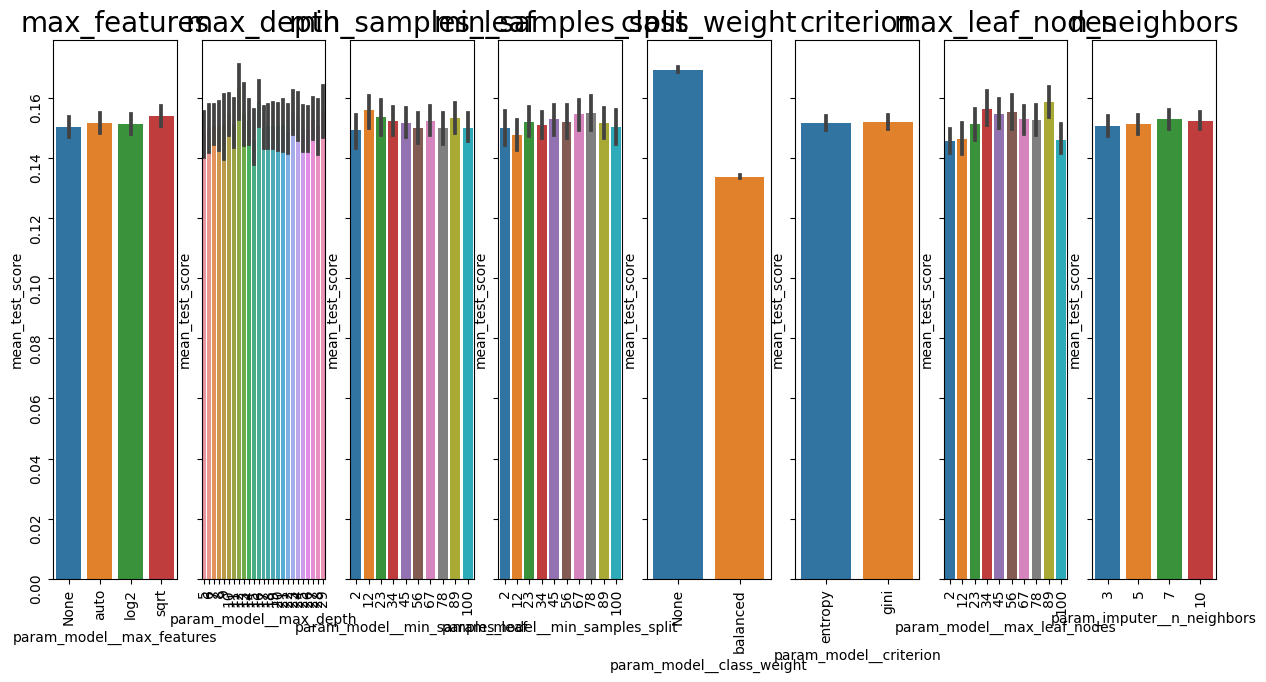

In [202]:
# графики, показывающие средний скор в зависимости от значения параметра
params_to_show = columns_to_show[:-2]
fig, axs = plt.subplots(ncols=len(params_to_show), nrows=1, sharey=True)
fig.set_size_inches(15,7)
for i in range(len(params_to_show)):
    sns.barplot(x=params_to_show[i], y='mean_test_score', data=rs_df, ax=axs[i])
    axs[i].set_title(label = params_to_show[i][params_to_show[i].find('__')+2:], size=20)
    axs[i].tick_params(rotation=90)

Decision Tree в данной задаче показывает низкую эффективность, независимо от тюнинга гиперпараметров, так что перейдем к следующей модели.

## lightgbm

In [250]:
import lightgbm as lgb

In [351]:
gbm_pipeline = wooden_pipeline(lgb.LGBMClassifier(random_state=SEED))

In [353]:
%%time

param_grid = {
    'model__boosting_type': ['gbdt', 'dart', 'goss'],
    'model__num_leaves': [3,5,10,15,20,25,31,40],
    'model__max_depth': [-1,2,3,5,8,10,15,20,30],
    'model__n_estimators': [50, 100, 150, 200, 300, 500],
    'model__subsample': [0.7, 0.8, 0.9, 1],
    'model__class_weight': ['balanced', None]
}

lgb_gs = RandomizedSearchCV(gbm_pipeline, 
                  param_grid, 
                  n_iter = 200,
                  cv = 5, 
                  n_jobs=-1, 
                  verbose = 1,
                  scoring='f1_micro',
                  random_state=SEED)

lgb_gs.fit(X, Y)
print(lgb_gs.best_params_)
print(lgb_gs.best_score_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
{'model__subsample': 0.9, 'model__num_leaves': 3, 'model__n_estimators': 100, 'model__max_depth': 20, 'model__class_weight': None, 'model__boosting_type': 'goss'}
0.18529352172753932
CPU times: user 1h 34min 9s, sys: 3.51 s, total: 1h 34min 12s
Wall time: 17min 53s


In [354]:
# обрабатываем результаты работы
rs_df = pd.DataFrame(lgb_gs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df[rs_df.mean_test_score.notna()]

columns_to_show = ['param_' + x for x in param_grid.keys()] + ['mean_test_score', 'rank_test_score']
rs_df = rs_df[columns_to_show]
rs_df = rs_df.fillna('None')
rs_df.head(10)

,param_model__boosting_type,param_model__num_leaves,param_model__max_depth,param_model__n_estimators,param_model__subsample,param_model__class_weight,mean_test_score,rank_test_score
0,goss,3,20,100,0.900,None,0.185,1
1,gbdt,3,10,200,0.900,None,0.185,2
2,gbdt,3,15,200,0.700,None,0.185,2
3,gbdt,5,8,100,0.700,None,0.185,4
4,dart,10,3,500,1.000,None,0.185,5
5,gbdt,15,2,150,0.900,None,0.185,6
6,goss,5,3,100,0.900,None,0.184,7
7,gbdt,5,2,200,0.800,None,0.184,8
8,gbdt,20,2,200,1.000,None,0.184,8
9,gbdt,3,-1,150,0.700,None,0.184,10


,param_model__boosting_type,param_model__num_leaves,param_model__max_depth,param_model__n_estimators,param_model__subsample,param_model__class_weight,mean_test_score,rank_test_score
0,goss,3,20,100,0.900,None,0.185,1
1,gbdt,3,10,200,0.900,None,0.185,2
2,gbdt,3,15,200,0.700,None,0.185,2
3,gbdt,5,8,100,0.700,None,0.185,4
4,dart,10,3,500,1.000,None,0.185,5


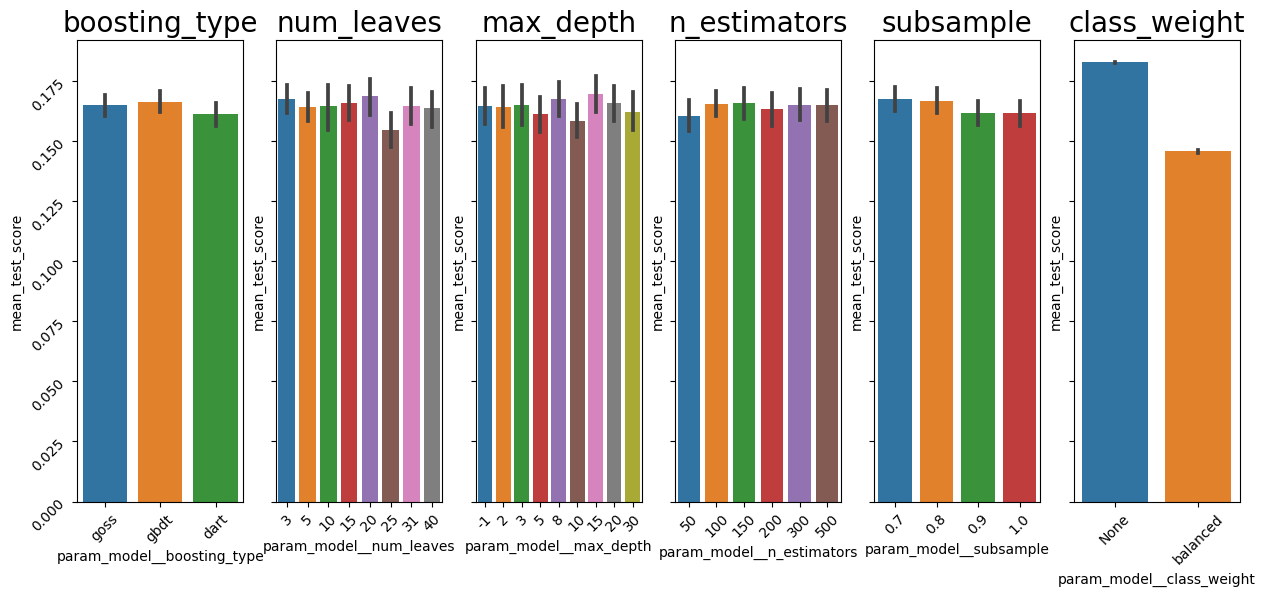

In [355]:
# графики, показывающие средний скор в зависимости от значения параметра
params_to_show = columns_to_show[:-2]
fig, axs = plt.subplots(ncols=len(params_to_show), nrows=1, sharey=True)
fig.set_size_inches(15,6)

display(rs_df.head())

for i in range(len(params_to_show)):
    sns.barplot(x=params_to_show[i], y='mean_test_score', data=rs_df, ax=axs[i])
    axs[i].set_title(label = params_to_show[i][params_to_show[i].find('__')+2:], size=20)
    axs[i].tick_params(rotation=45)

LightGBM в данной задаче показывает низкую эффективность, независимо от тюнинга гиперпараметров.

## Вывод

- Были обучены модели: LogisticRegression, SVM, KNN, DecisionTree, LightGBM
- Разведка наилучших гиперпараметров проводилась с помощью RandomizedSearchCV, затем результаты визуализировались. Цель - найти диапазоны наиболее подходящих значений.Затем, для модели SVM, показавшей лучший результат, проводился GridSearchCV для максимизации скора.
- Лучший результат показала модель SVM с f1_micro = 0.446.
- На основании этой модели будут делаться дальнейшие предсказания

# Создание предсказаний

## Открываем и обрабатываем файл с тестовыми данными

In [165]:
test = pd.read_csv('kaggle_music_genre_test.csv')

In [166]:
test.shape

(5099, 15)

In [167]:
test = prepare_raw(test)

In [168]:
test.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,mode,speechiness,tempo,valence
instance_id,,,,,,,,,,,
48564,0.301,0.757,146213.000,0.679,0.000,A#,0.303,Minor,0.356,90.361,0.895
72394,0.538,0.256,240360.000,0.523,0.008,G#,0.085,Major,0.029,78.385,0.318
88081,0.006,0.678,284000.000,0.770,0.000,A,0.109,Minor,0.222,90.000,0.412
78331,0.020,0.592,177354.000,0.749,0.000,B,0.122,Major,0.048,160.046,0.614
72636,0.000,0.421,-1.000,0.447,0.015,D,0.037,Major,0.202,73.830,0.121


In [169]:
test.shape

(5099, 11)

## Создаем csv-файл с предсказанием

In [176]:
predictions = fine_gs.predict(test)

In [177]:
predictions = pd.DataFrame(data={'instance_id': test.index, 'music_genre': predictions} )

In [178]:
predictions.shape

(5099, 2)

In [203]:
predictions.head()

,instance_id,music_genre
0,48564,Rap
1,72394,Alternative
2,88081,Rap
3,78331,Country
4,72636,Rap


In [180]:
predictions.to_csv('predictions.csv', index=False)